# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые перешли на тарифы "Смарт" и "Ультра". Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

**Задача**: построить рекомендационную модель с максимально большим значением *accuracy* - не менее `0.75`.

**Данные** содержат `3214` строк и 5 столбцов:
 - `сalls` — количество звонков,
 - `minutes` — суммарная длительность звонков в минутах,
 - `messages` — количество sms-сообщений,
 - `mb_used` — израсходованный интернет-трафик в Мб,
 - `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — `1`, «Смарт» — `0`)

## Откроем и изучим файл

Подключим все необходимые библиотеки.

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn import tree
#возьмем набор моделей из библиотеки scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
#добавим метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

Откроем файл.

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Данные не содержат пропусков. Типы данных в порядке.

## Разобъем данные на выборки

### Разбиение на обучающую, тестовую и валидационную

Разобъем данные на обучающую, валидационную и тестовую выборку в процентах от общей: `70%`, `15%` и `15%` соответсвенно.

In [4]:
#отделим факторы и целевой признак
features = data.drop(['is_ultra'], axis=1)
target = data['is_ultra']

#отделим основную выборку
features_train, features_check, target_train, target_check = train_test_split(features,
                                                                         target,
                                                                         train_size=0.7,
                                                                         random_state=0)
#отделим валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_check,
                                                                            target_check,
                                                                            train_size=0.5,
                                                                            random_state=0)
#выведем размерность получившихся выборок
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (2249, 4)
Размер валидационной выборки: (482, 4)
Размер тестовой выборки: (483, 4)


Выборки разбиты в соответсвии с необходимыми пропорциями. В каждой достаточно данных.

### Балансировка

Проверим сбалансирована ли обучающая выборка.

In [5]:
target_train.value_counts()

0    1558
1     691
Name: is_ultra, dtype: int64

Тариф "Смарт" встречается в два раза чаще. В дальнейшем это может привести к перекосу моделю в пользу рекомендации этого тарифа. Удалим 55% от данных по тарифу "Смарт".

In [6]:
#разобьем данные на две группы по тарифам
train_data_ultra = features_train.join(target_train).query('is_ultra==1')
train_data_smart = features_train.join(target_train).query('is_ultra==0')
#сократим обьем данных по тарифу смарт
train_data_smart_first_half, train_data_second_half = train_test_split(train_data_smart,
                                                                       train_size=0.45,
                                                                       random_state=0)
#перезапишем обучающую выборку
train_data = pd.concat([train_data_ultra, train_data_smart_first_half])
features_train = train_data.drop(['is_ultra'], axis=1)
target_train = train_data['is_ultra']
#проверим обьем групп
target_train.value_counts()

0    701
1    691
Name: is_ultra, dtype: int64

Выборки сбалансированы.

### Вывод по главе 2

Данные подготовлены. Выбрки разбиты на обучающую, валидационную и тестовую в долях `70%`/`15%`/`15%`. Часть данных по группе тарифа "Смарт" удалена для балансировки выборок.

## Исследуем модели

### Проверим данные на мультиколлинеарность

Построим матрицу корреляций и графики зависимости факторов для анализа мультиколлинеарности предикторов.

In [7]:
data.corr().round(3)

,calls,minutes,messages,mb_used,is_ultra
calls,1.000,0.982,0.177,0.286,0.207
minutes,0.982,1.000,0.173,0.281,0.207
messages,0.177,0.173,1.000,0.196,0.204
mb_used,0.286,0.281,0.196,1.000,0.199
is_ultra,0.207,0.207,0.204,0.199,1.000


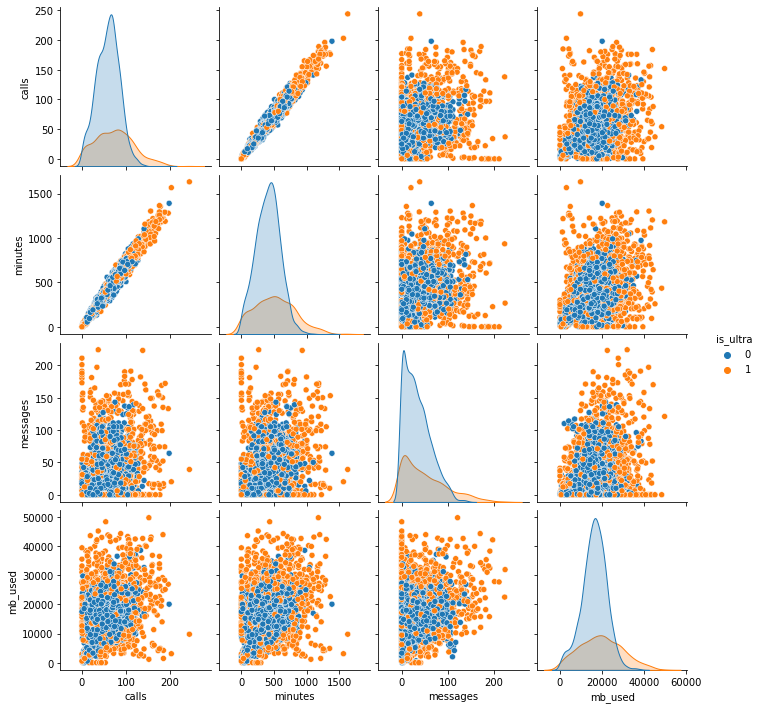

In [89]:
#построим попарный график
sns.pairplot(data, hue='is_ultra')

Видна сильная связь факторов `calls` и `minutes` - коэф. корреляции почти единица. Это разумно, ведь количество минут напрямую зависит от количества звонков.

Для того, чтобы понять какой фактор исключить рассчитаем коэф. корреляции Спирмена. Он покажет, какой из факторов теснее связан с целевой переменной.

In [9]:
data[['calls', 'minutes', 'is_ultra']].corr(method='spearman').round(3)

,calls,minutes,is_ultra
calls,1.000,0.979,0.161
minutes,0.979,1.000,0.160
is_ultra,0.161,0.160,1.000


Исключим из всех выборок предиктор `minutes`. Звонки (`calls`) показывает бо́льшую, хоть и невысокую связь.

In [10]:
#удалим столбец из всех выборок
features_train = features_train.drop(['minutes'], axis=1)
features_valid = features_valid.drop(['minutes'], axis=1)
features_test = features_test.drop(['minutes'], axis=1)
#выведем размерность получившихся выборок
print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (1392, 3)
Размер валидационной выборки: (482, 3)
Размер тестовой выборки: (483, 3)


### Сравним качество набора моделей

#### Дерево решений (DecisionTreeClassifier)

При построении дерева решений будем варьировать гиперпараметр `max_dept` - глубина дерева. В целевой переменной всего два класса это значит, что минимальное глубина дерева может быть 1. Проверим accuracy при `max_dept`от  1 до 10.

In [11]:
#создадим словарь (точность:глубина дерева)
dtc_accuracy_dict = dict()

#построим модели с разной глубиной дерева max_dept
for depth in range(1, 11):
    #инициализируем модель
    model_dtc = DecisionTreeClassifier(max_depth=depth, random_state=0)
    #обучим модель
    model_dtc.fit(features_train, target_train)
    #оценим точность на валидационной выборке
    accuracy_dtc = accuracy_score(model_dtc.predict(features_valid), target_valid)
    #сохраним лучшую модель
    if len(dtc_accuracy_dict)>0:
        if accuracy_dtc >= max(dtc_accuracy_dict):
            best_dtc_model = model_dtc
    else:
        best_dtc_model = model_dtc
    #добавим точность и параметр глубины дерева в словарь
    dtc_accuracy_dict[accuracy_dtc] = depth
    
#выведем глубину и точность самого точного решения
print('Макс. глубина дерева: {}, точность: {:.2}'.format(dtc_accuracy_dict[max(dtc_accuracy_dict)], max(dtc_accuracy_dict)))

Макс. глубина дерева: 5, точность: 0.8


#### Случайный лес (RandomForestClassifier)

При построении случайного леса будем варьировать гиперпараметр n_estimators - количество деревьев.Проверим accuracy при n_estimators от 1 до 10.

In [12]:
#создадим словарь (точность:кол-во деревьев)
rfc_accuracy_dict = dict()

#построим модели с разным кол-вом деревьев
for estimators in range(1, 11):
    #инициализируем модель
    model_rfc = RandomForestClassifier(n_estimators=estimators, random_state=0)
    #обучим модель
    model_rfc.fit(features_train, target_train)
    #оценим точность на валидационной выборке
    accuracy_rfc = accuracy_score(model_rfc.predict(features_valid), target_valid)
    #сохраним лучшую модель
    if len(rfc_accuracy_dict)>0:
        if accuracy_rfc >= max(rfc_accuracy_dict):
            best_rfc_model = model_rfc
    else:
        best_rfc_model = model_rfc
        
    #добавим точность и параметр кол-вом деревьев в словарь
    rfc_accuracy_dict[accuracy_rfc] = estimators

#выведем кол-во и точность самого точного решения
print('Кол-во деревьев: {}, точность: {:.2}'.format(rfc_accuracy_dict[max(rfc_accuracy_dict)], max(rfc_accuracy_dict)))

Кол-во деревьев: 8, точность: 0.75


#### Регрессия Риджа (RidgeClassifier)

При построении модели классификации Риджа будем варьировать гиперпараметр solver - решатель. Проверим accuracy следующих решателей:
- `svd` использует разложение X по сингулярным значениям для вычисления коэффициентов Риджа. Это наиболее стабильный решатель, в частности, более стабильный для сингулярных матриц, чем «cholesky», но он медленнее;
- `cholesky` использует стандартную функцию scipy.linalg.solve для получения решения в закрытой форме;
- `lsqr`использует специальную регуляризованную процедуру наименьших квадратов scipy.sparse.linalg.lsqr. Это самый быстрый метод, в котором используется итеративная процедура.;
- `sparse_cg` использует решатель сопряженных градиентов, который можно найти в scipy.sparse.linalg.cg.;
- `sag`использует стохастический средний градиентный спуск;
- `saga`использует стохастический средний градиентный спуск.
<br>[Описание - перевод из документации по модели.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)

In [13]:
#создадим словарь (точность:решатель)
ridge_accuracy_dict = dict()

#построим модели с разными решателями
for solver in ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']:
    #инициализируем модель
    model_ridge = RidgeClassifier(solver=solver, random_state=0)
    #обучим модель
    model_ridge.fit(features_train, target_train)
    #оценим точность на обучающей выборке
    accuracy_ridge = accuracy_score(model_ridge.predict(features_train), target_train)
    #сохраним лучшую модель
    if len(ridge_accuracy_dict)>0:
        if accuracy_ridge >= max(ridge_accuracy_dict):
            best_ridge_model = model_ridge
    else:
        best_ridge_model = model_ridge

    #добавим точность и решатель в словарь
    ridge_accuracy_dict[accuracy_ridge] = solver
    
#выведем решатель и самое точное решение
print('Лучший решатель: {}, точность: {:.2}'.format(ridge_accuracy_dict[max(ridge_accuracy_dict)], max(ridge_accuracy_dict)))

Лучший решатель: cholesky, точность: 0.65


#### Метод k-ближайших соседей (KNeighborsClassifier)

При построении случайного леса будем варьировать гиперпараметр `n_neighbors`- количество соседей. Проверим accuracy при n_neighbors от 1 до 100. Также будем варировать гиперпараметры `weights` и `algorithm`.

Веса (`weights`):
- `uniform`: одинаковые веса. Все точки в каждой окрестности имеют одинаковый вес.
- `distance`: вес точек обратно пропорционален их расстоянию. в этом случае более близкие соседи точки запроса будут иметь большее влияние, чем соседи, находящиеся дальше.

Алгоритм (`weights`):
- `ball_tree`: будет использоваться [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree).
- `kd_tree`: будет использовать [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree).
- `brute`: будет использовать грубый перебор.

<br>[Описание - перевод из документации по модели.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [ ]:
#создадим словарь (точность:кол-во соседей)
kn_accuracy_dict = dict()

#построим модели с разными кол-вами соседей
for neighbors in range(1, 101):
        for weights in ('uniform', 'distance'):
            for algorithm in ('ball_tree', 'kd_tree', 'brute'):
                #инициализируем модель
                model_kn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm)
                #обучим модель
                model_kn.fit(features_train, target_train)
                #оценим точность на валидационной выборке
                accuracy_kn = accuracy_score(model_kn.predict(features_valid), target_valid)
                #сохраним лучшую модель
                if len(kn_accuracy_dict)>0:
                    if accuracy_kn >= max(kn_accuracy_dict):
                        best_kn_model = model_kn
                else:
                    best_kn_model = model_kn
                #добавим точность и кол-во соседей в словарь
                kn_accuracy_dict[accuracy_kn] = (neighbors, weights, algorithm)

In [15]:
#выведем кол-во соседей и самое точное решение
print('Кол-во соседей:', kn_accuracy_dict[max(kn_accuracy_dict)][0])
print('Веса:', kn_accuracy_dict[max(kn_accuracy_dict)][1])
print('Алгоритм:', kn_accuracy_dict[max(kn_accuracy_dict)][2])
print('Tочность: {:.2}'.format(max(kn_accuracy_dict)))

Кол-во соседей: 8
Веса: uniform
Алгоритм: brute
Tочность: 0.74


#### Линейный метод опорных векторов (LinearSVC) 

При построении линейной модели метода опорных векторов будем варьировать гиперпараметры типа функции потерь (`loss`) и силы регуляризации.

- `loss` - задает функцию потерь. `hinge` — это стандартные потери SVM, а `squared_hinge` — это квадрат потерь функции `hinge`.
- `C` - задает силу регуляризации. Регуляризация помогает в избежать переобучения - накладывает штраф за усложенине модели.

In [ ]:
#создадим словарь (точность: кортеж(функция потерь и сила регуляризации))
svc_accuracy_dict = dict()

#построим модели с функциями потерь и регуляризацией
for loss in ['hinge', 'squared_hinge']:
    for c in range(1, 11):
        for tol in range(1, 11):
            #инициализируем модель
            model_svc = LinearSVC(loss=loss, C=c,tol=tol*0.01, random_state=0)
            #обучим модель
            model_svc.fit(features_train, target_train)
            #оценим точность на валидационной выборке
            accuracy_svc = accuracy_score(model_svc.predict(features_valid), target_valid)
            #сохраним лучшую модель
            if len(svc_accuracy_dict)>0:
                if accuracy_svc >= max(svc_accuracy_dict):
                    best_svc_model = model_svc
            else:
                best_svc_model = model_svc
            
        #добавим точность и кортеж(функция потерь и сила регуляризации) в словаь
        svc_accuracy_dict[accuracy_svc] = (loss, c, tol*0.1)

In [17]:
#выведем функция потерь, пареметр регуляризации и самое точное решение
print('Функция потерь: {}'.format(svc_accuracy_dict[max(svc_accuracy_dict)][0]))
print('Пареметр регуляризации: {}'.format(svc_accuracy_dict[max(svc_accuracy_dict)][1]))
print('Точность: {:.2}'.format(max(svc_accuracy_dict)))

Функция потерь: hinge
Пареметр регуляризации: 7
Точность: 0.72


#### Логистическая регрессия (LogisticRegression)

При построении модели логистической регрессии будем варьировать гиперпараметр решателя: `liblinear`, `newton-cg`, `lbfgs`, `sag`, `saga`.

In [ ]:
#создадим словарь (точность: решатель)
lr_accuracy_dict = dict()

#построим модели с разными решателями
for solver in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']:
    #инициализируем модель
    model_lr = LogisticRegression(solver=solver, random_state=0)
    #обучим модель
    model_lr.fit(features_train, target_train)
    #оценим точность на валидационной выборке
    accuracy_lr = accuracy_score(model_lr.predict(features_valid), target_valid)
    #добавим точность и решатель
    lr_accuracy_dict[accuracy_lr] = solver
    #сохраним лучшую модель
    if len(lr_accuracy_dict)>0:
        if accuracy_lr >= max(lr_accuracy_dict):
            best_lr_model = model_lr
        else:
            best_lr_model = model_lr

In [20]:
#выведем решатель. регуляризацию и самое точное решение
print('Лучший решатель: {}'.format(lr_accuracy_dict[max(lr_accuracy_dict)]))
print('Точность: {:.2}'.format(max(lr_accuracy_dict)))

Лучший решатель: newton-cg
Точность: 0.62


#### Вывод по главе 3

Все выбранные модели показали точность (*accuracy*) более `0.62` на валидационной выборке. Построим таблицу по всем алгоритмам.

| Алгоритм | Точность (валид.)| Гиперпараметр(ы) | Значение гиперпараметра |
|----------|------------------|------------------|--------------------------|
| DecisionTreeClassifier | 0.8 | Макс. глубина дерева      | 5 |
| RandomForestClassifier | 0.75 | Кол-во деревьев | 8 |
| KNeighborsClassifier | 0.75 | Кол-во соседей, веса, алгоритм | 8, uniform, brute|
| LogisticRegression | 0.74 | Решатель | newton-cg |
| LinearSVC | 0.72 | Функция потерь, регуляризация | hinge,  7|
| RidgeClassifier | 0.64 | Решатель| cholesky |

## Проверим модели на тестовой выборке

Проверим две наилучшие модели на тестовой выборке. Посчитаем параметр *accuracy* для каждой модели, при наилучших гиперпараметрах. Для более полной оценки моделей также добавим метрики *precision* и *recall*.

In [86]:
#создадим список моделей
models = [best_dtc_model,
          best_rfc_model]

accuracy_models_list = []
#в цикле перебеорем модели
for model in models:
    #рассчитаем точность на тестовой выборке
    accuracy = accuracy_score(model.predict(features_test), target_test)
    #рассчитаем precision на тестовой выборке
    precision = precision_score(model.predict(features_test), target_test)
    #рассчитаем recall на тестовой выборке
    recall = recall_score(model.predict(features_test), target_test)
    #добавим в список результатов подсписок [модель, название алгоритма, точность]
    accuracy_models_list.append([model, str(model).split('(')[0], accuracy, precision, recall])
    
#переведем лист в датафрем для удобства вывода
accuracy_models_df = pd.DataFrame(accuracy_models_list)
#переименуем столбцы
accuracy_models_df.columns = ['модель', 'алгоритм', 'accuracy', 'precision', 'recall']
#округлим
accuracy_models_df[['accuracy', 'precision', 'recall']] = accuracy_models_df[['accuracy', 'precision', 'recall']].round(2)
#выведем название алгоритма и все метрики
accuracy_models_df[['алгоритм', 'accuracy', 'precision', 'recall']].sort_values(by='accuracy', ascending=False)

,алгоритм,accuracy,precision,recall
0,DecisionTreeClassifier,0.80,0.57,0.73
1,RandomForestClassifier,0.75,0.66,0.59


1. На валидационной выборке все алгоритмы показали большую точность, по сравнению с тестовой. 
2. Алгоритмы на основе деревьев показывают себя лучше и по совокупности метрик.
3. Алгоритмы ниже показывают бо́льший *recall*, но небольшой *precision*. Можно предположить, что эти модели чаще рекомендуют тариф "Ультра", возможно, рекомендуют его почти всем. В связи с этим растет количество как ложноположительных и истиноположительных, что увеличивает знаменатель метрики *precision*.
4. Среди всех моделей наилучую точность (*accuracy*) показал алгоритм дерева решений ~ `0.8`.

### Вывод по главе 4

Наилучшим алгоритмом является дерево решений (DecisionTreeClassifier) с показателем *accuracy* ~ `0.8` на тестовой выборке.

## Проверим модели на адекватность

### Структура дерева решений

Посмотрим как выглядит получившееся дерево решений.

In [54]:
print(export_text(best_dtc_model, feature_names=list(features_train.columns)))

|--- mb_used <= 26244.13
|   |--- calls <= 99.50
|   |   |--- messages <= 114.50
|   |   |   |--- mb_used <= 8183.38
|   |   |   |   |--- calls <= 40.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- calls >  40.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- mb_used >  8183.38
|   |   |   |   |--- calls <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- calls >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- messages >  114.50
|   |   |   |--- class: 1
|   |--- calls >  99.50
|   |   |--- calls <= 128.50
|   |   |   |--- messages <= 13.50
|   |   |   |   |--- mb_used <= 23463.13
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- mb_used >  23463.13
|   |   |   |   |   |--- class: 0
|   |   |   |--- messages >  13.50
|   |   |   |   |--- messages <= 48.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- messages >  48.00
|   |   |   |   |   |--- class: 1
|   |   |--- calls >  128.50
|   |   |   |--- calls <= 193.50
|   |   |   |   |--- class: 1


Дерево получилось громоздким. Это ожидаемо при таком параметре максимальной глубины. Сложно найти простой принцип, по которму модель классифицировала абонентов. Но, например, в корне дерева оказалось деление по использованному трафику `mb_used` больше/меньше `26244.13` МБ.

Попробуем визуализировать дерево в виде иерархического графа.

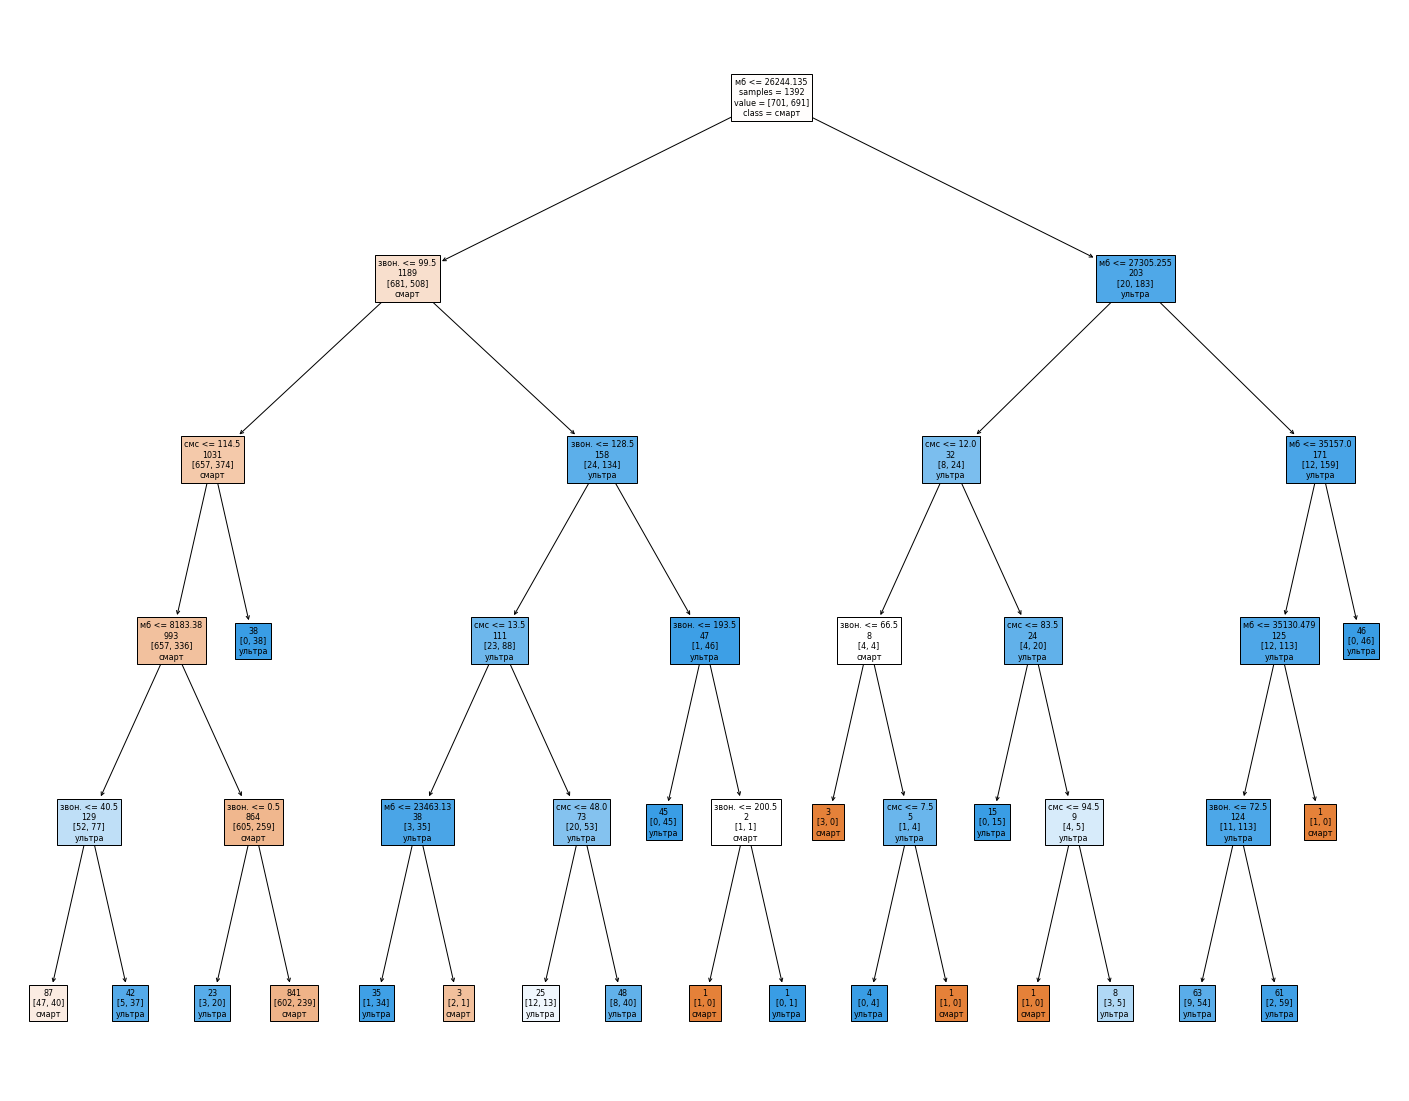

In [55]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_dtc_model, 
                   feature_names=['звон.','смс', 'мб'],  
                   class_names=['смарт', 'ультра'],
                   label='root',
                   impurity=False,
                   filled=True)

Можно рассмотреть логику разбиения на группы по тарифам. Например:
- Если трафик от `~26 244`, звонков до `~99`, смс от `~114`, то рекомендуем тариф "Ультра" (левая короткая ветка, глубиной 3). В этой группе 38 точек.
- Если трафик от `~35 130` до `~35 157`, то рекомендуем тариф "Смарт" (вторая справа короткая ветка, глубиной 4). В этой группе всего одна точка.
- Если трафик от `~8 183` до `~26 244`, звонки от `~0` до `~99`,а смс до `~114`, то рекомендуем тариф "Смарт". Это самый большой лист (четвертый слева), в этой группе 841 точка.

Некоторые группы имеют физический смысл, такие как группа абонентов "Смарт" со средним трафиком, небольшим кол-вом звонков и смс. Некоторые группы не очень хорошо интерпритируются (такие как группа с трафиком от 35130 до 35157), но они возникают из-за механики алгоритма.

### Матрицы ошибок

Построим матрицы ошибок двух алгоритмов с наибольшей точностью на тестовой выборке.

In [56]:
#соберем модели в один датасет
test_data_best_models = features_test.copy()
test_data_best_models['is_ultra'] = target_test.copy()
test_data_best_models['is_ultra_dtc'] = best_dtc_model.predict(features_test)
test_data_best_models['is_ultra_rfc'] = best_rfc_model.predict(features_test)

Матрица ошибок дерева решений.

Text(33.0, 0.5, 'прогнозные')

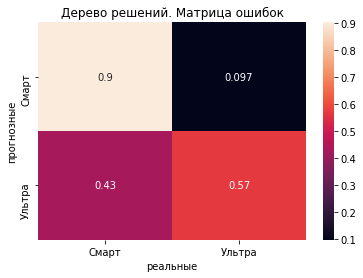

In [57]:
#построим матрицу ошибок
cf = confusion_matrix(target_test, best_dtc_model.predict(features_test), normalize='true')
#построим хитмап по матрице ошибок
ax = sns.heatmap(cf, annot=True,
                 xticklabels=['Смарт', 'Ультра'],
                 yticklabels=['Смарт', 'Ультра'])
#подпишем оси и график
ax.set_title('Дерево решений. Матрица ошибок')
ax.set_xlabel('реальные')
ax.set_ylabel('прогнозные')

1. Дерево решений хорошо вычисляет тех, кому подойдет "Смарт".
2. Когда на вход алгоритму попадает реальный абонент тарифа "Ультра" он угадывает чуть больше чем в половине случаев.
3. Можно говорить о перекосе прогноза в пользу тарифа "Смарт".

Матрица ошибок случайного леса.

Text(33.0, 0.5, 'прогнозные')

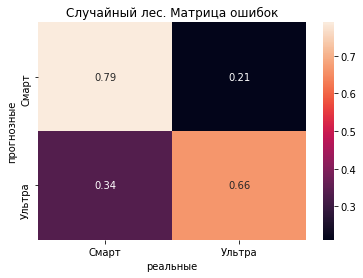

In [58]:
#построим матрицу ошибок
cf = confusion_matrix(target_test, best_rfc_model.predict(features_test), normalize='true')
#построим хитмап по матрице ошибок
ax = sns.heatmap(cf, annot=True,
                 xticklabels=['Смарт', 'Ультра'],
                 yticklabels=['Смарт', 'Ультра'])
#подпишем оси и график
ax.set_title('Случайный лес. Матрица ошибок')
ax.set_xlabel('реальные')
ax.set_ylabel('прогнозные')

1. Случайный лес неплохо вычисляет реальных абонентов тарифа "Смарт", но хуже дерева решений.
2. В 2/3 случаях алгоритм рекомендовал "Ультра" реальным абонентам тарифа.
3. Возможно случайный лес более cбалансированный. Имеет меньший перекос в пользу тарифа "Смарт", по сравнению с решающщим лесом.

Проверим сбарансированную точность. Возможно она выше у алгоритма случайного леса.

In [59]:
print('Сбалансированная точность дерева решений: {:.2}'.format(balanced_accuracy_score(target_test, best_dtc_model.predict(features_test))))
print('Сбалансированная точность случайного леса: {:.2}'.format(balanced_accuracy_score(target_test, best_rfc_model.predict(features_test))))

Сбалансированная точность дерева решений: 0.74
Сбалансированная точность случайного леса: 0.73


Дерево решений лучше и по сбалансированной точности. 

### Визуализация классификации

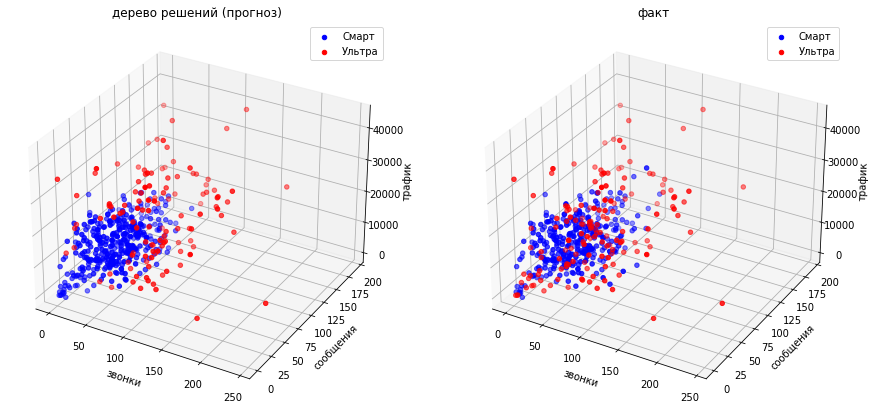

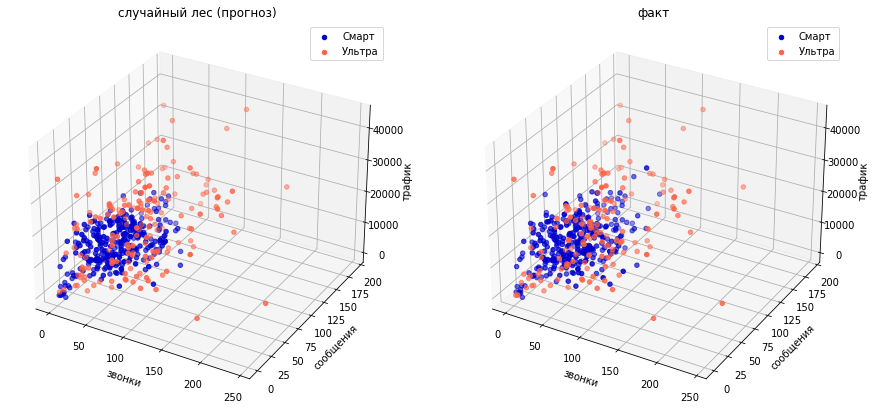

In [60]:
#создадим фигуру для дерева решений
fig = plt.figure(figsize=(15, 15))
#добавим точки Ультра-прогноз
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(test_data_best_models.query('is_ultra_dtc==0')['calls'],
           test_data_best_models.query('is_ultra_dtc==0')['messages'],
           test_data_best_models.query('is_ultra_dtc==0')['mb_used'],
           label='Смарт',
           color='blue')
#добавим точки Смарт-прогноз
ax.scatter(test_data_best_models.query('is_ultra_dtc==1')['calls'],
           test_data_best_models.query('is_ultra_dtc==1')['messages'],
           test_data_best_models.query('is_ultra_dtc==1')['mb_used'],
           label='Ультра',
           color='red')
#настроим подпись и легенду
ax.set_title('дерево решений (прогноз)')
ax.set_xlabel('звонки')
ax.set_ylabel('сообщения')
ax.set_zlabel('трафик')
ax.legend()
ax.grid()

#добавим точки Ультра-факт
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(test_data_best_models.query('is_ultra==0')['calls'],
           test_data_best_models.query('is_ultra==0')['messages'],
           test_data_best_models.query('is_ultra==0')['mb_used'],
           label='Смарт',
           color='blue')
#добавим точки Смарт-факт
ax.scatter(test_data_best_models.query('is_ultra==1')['calls'],
           test_data_best_models.query('is_ultra==1')['messages'],
           test_data_best_models.query('is_ultra==1')['mb_used'],
           label='Ультра',
           color='red')
#настроим подпись и легенду
ax.set_title('факт')
ax.set_xlabel('звонки')
ax.set_ylabel('сообщения')
ax.set_zlabel('трафик')
ax.legend()
ax.grid()

#создадим фигуру для случайного леса
fig = plt.figure(figsize=(15, 15))
#добавим точки Ультра-прогноз
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(test_data_best_models.query('is_ultra_rfc==0')['calls'],
           test_data_best_models.query('is_ultra_rfc==0')['messages'],
           test_data_best_models.query('is_ultra_rfc==0')['mb_used'],
           label='Смарт',
           color='mediumblue')
#добавим точки Смарт-прогноз
ax.scatter(test_data_best_models.query('is_ultra_rfc==1')['calls'],
           test_data_best_models.query('is_ultra_rfc==1')['messages'],
           test_data_best_models.query('is_ultra_rfc==1')['mb_used'],
           label='Ультра',
           color='tomato')
#настроим подпись и легенду
ax.set_title('случайный лес (прогноз)')
ax.set_xlabel('звонки')
ax.set_ylabel('сообщения')
ax.set_zlabel('трафик')
ax.legend()
ax.grid()

#добавим точки Ультра-факт
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(test_data_best_models.query('is_ultra==0')['calls'],
           test_data_best_models.query('is_ultra==0')['messages'],
           test_data_best_models.query('is_ultra==0')['mb_used'],
           label='Смарт',
           color='mediumblue')
#добавим точки Смарт-факт
ax.scatter(test_data_best_models.query('is_ultra==1')['calls'],
           test_data_best_models.query('is_ultra==1')['messages'],
           test_data_best_models.query('is_ultra==1')['mb_used'],
           label='Ультра',
           color='tomato')
#настроим подпись и легенду
ax.set_title('факт')
ax.set_xlabel('звонки')
ax.set_ylabel('сообщения')
ax.set_zlabel('трафик')
ax.legend()
ax.grid()

1. Дерево решений формирует более четкие границы облака для тарифа "Смарт", внутри которых почти не встречаются точки, относящиеся к тарифу "Ультра". Область: звонки (`0`, `50`), трафик (`0`, `10 000`).
2. Случайный лес визуально дает более адекватную картину. Область тарифов пересекается в большей степени.
3. Оба алгоритма отнесли точки с большими показателями звонков и трафика к тарифу "Ультра". Нельзя сказать тоже самое про сообщения.

### Сравним результат с фиктивной моделью

Сравним результаты работы моделей с фиктивным классификатором. В стратегии `most_frequent` классификатор всегда воспроизводит метку самого частовстреающегося класса. В стратегии `uniform` - "бросает монетку".

In [ ]:
for strategy in ('most_frequent', 'uniform'):
    model_dummy = DummyClassifier(strategy=strategy, random_state=0)
    model_dummy.fit(features_train, target_train)
    model_dummy.predict(features_test)
    #рассчитаем точность на тестовой выборке
    accuracy = accuracy_score(model_dummy.predict(features_test), target_test)
    #рассчитаем precision на тестовой выборке
    precision = precision_score(model_dummy.predict(features_test), target_test)
    #рассчитаем recall на тестовой выборке
    recall = recall_score(model_dummy.predict(features_test), target_test)
    #добавим в список результатов подсписок [модель, название алгоритма, точность]
    accuracy_models_list.append([model, str(model_dummy).split('(')[0]+'('+strategy+')', accuracy, precision, recall])
    #переведем лист в датафрем для удобства вывода
    accuracy_models_df = pd.DataFrame(accuracy_models_list)
    #переименуем столбцы
    accuracy_models_df.columns = ['модель', 'алгоритм', 'accuracy', 'precision', 'recall']
    #округлим
    accuracy_models_df[['accuracy', 'precision', 'recall']] = accuracy_models_df[['accuracy', 'precision', 'recall']].round(2)
#выведем название алгоритма и все метрики
accuracy_models_df[['алгоритм', 'accuracy', 'precision', 'recall']].sort_values(by='accuracy', ascending=False)

1. В стратегии выбора самого частого класса модель показала `0.69` *accuracy*, что выше некоторых предыдущих исследумых моделей. Это ожидаемо, ведь `0.69` это есть примерная доля самого большого класса в данных, и как следствие в тестовой выборке.
2. В рандомной стратегии классификатор показал `0.49`. Это также ожидаемо, тестовых данных достаточно, чтобы показать приблизится к мат. ожиданию распределения.
3. Оба алгоритма работают лучше чем фиктивная модель по всем показателям.

### Выводы по главе 5

1. Метрики *precision* и *recall* показали корректность работы алгоритмов решающего дерева и случайного леса.
2. Судя по матрице ошибок случайных лес более коррекно определяет пользователей тарифа "Ультра". А дерево решений абонентов "Смарт".
3. Дерево решений точнее как по *accuracy*, так и по сбалансированной точности.
4. Обе модели работают лучше, чем рандом и угадывание метки самого большого класса.

## Выводы

Целью было: построить рекомендационную модель со значением *accuracy* - не менее `0.75`.

Удалось построить модель классификации соответсвующих данному условию. Первая модель на основе **дерева решений** с точностью `0.8`. Вторая - на основе **случайного леса** с точностью `0.75`.

Дерево решений хорошо вычисляет характерных абонентов тарифа "Смарт", но почти в половине случаев ошибается в определении реального абонента тарифа "Ультра". Случайный лес менее точен, но меньше ошибается в абонентах "Ультра". С точки зрения практики, в редких случаях модель на основе случайного леса может оказаться эффективнее. Например, в случае, если тариф "Ультра" дорогой, и упустить потенциального абонента стоит большой альтернативной выгоды. Эти особенности моделей можно учесть при выработке реальных бизнес-решений.

По различным метрикам качества лучше модель на основе **дерева решений**, предпочтительно использовать её.